In [ ]:
import pystan
import numpy as np
from pystan import StanModel

# here we try to get the quantile table for both Fisher and GPD
normal = """
functions {
  // Define log probability density function
  // we define desired probability distributions manually
  real myNormal_lpdf(real y1, real mu, real sigma) {
    return -log(2 * pi()) / 2 - log(sigma) - square(mu - y1) / (2 * sigma^2);
  } 

}
data { 
  // data points sampled from the given distribution from Python Scipy 
  int N;
  real y1[N]; // points sampled from normal in python with some(known) parameters, by mcmc we recover true values of those params
 }
parameters { 
  // parameters of the normal distributions & Fisher & GPD
  real mu;
  real<lower = 0> sigma;
}
model {
 // Priors, not specifying priors is equal to improper prior 
  
 //  mu ~ normal(0, 10);
 //  sigma ~ cauchy(0,10);
  
  // Likelihood
  for(n in 1:N) {
    target +=  myNormal_lpdf( y1[n] | mu, sigma ); 
  }

}

generated quantities{}
"""

we try to recover original parameters from normal distribution, we provide data sampled from N(2,1)

In [ ]:
n, p, N = 1, .5, 10  # number of trials, probability of each trial
s = np.random.normal(2,1, N)
# s1 = [1,1,1,1,1,1,1,1,1,1]
data = dict(N = N, y1 = s.tolist())#, y2 = s.tolist(), y3 = s.tolist()) # we provide data for our model, y is primarly an array, it needs to be converted to a list
sm = StanModel(model_code=normal) # we put the created model to the stan 
fit = sm.sampling(data=data)# we sample from the provided data ;
print(fit)

The model with normal simulations works, now we try the same with GPD density

In [1]:
# genereting random numbers from Frechet & Burr & log-gamma 
import pystan
import numpy as np
from pystan import StanModel 
from scipy.stats import frechet_r, loggamma, burr, invweibull
# from scipy.stats import burr
# from scipy.stats import loggamma
N = 5000
c = 1
# frechet_r.pdf(x, c) =c*x**(-c-1)*exp(-x**-c)
frechet = invweibull.rvs(c, size=N) # this is exactly the same as in publication, there beta = 1/c 

# burr distribution, burr(1, 1/2, 2)
# burr_r.pdf = c * d * x**(-c-1) * ( 1 + x**( -c ) )**(- d - 1)
c, d = 1, 0.5
burr = burr.rvs(c, d, size=N)

# log-gamma
# probability density for loggamma: loggamma.pdf(x, c) = exp(c*x-exp(x)) / gamma(c)
c = 2
loggamma = loggamma.rvs(c, size=N)

# i assume the pdfs are correct, now we need to save the k- greatest values from each distribution,
# save the k-th greatest value u, 
# get the array of x_i - u and to those data fit both GPD and Fisher distribution

In [9]:
# to get k-greatest value from which we subtract the border value

def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = [a-u for x in a]
    return(a[1].tolist(), u)

In [149]:
k = 100
data_frechet,u = k_greatest_values(frechet,k)
data_frechet

[0.17192324364231126,
 0.4984858895881459,
 2.1810267288829337,
 2.6330803282229027,
 3.6495618951010442,
 4.1900593158621575,
 4.5908834985053915,
 5.01701181784594,
 6.878865864091992,
 9.160421826678963,
 9.479394708335683,
 10.594151578273838,
 10.882035077462056,
 11.273445040684557,
 11.370616380637365,
 11.789070481091564,
 12.030376625598628,
 12.432003787721705,
 13.093229151213535,
 13.573499956040258,
 14.850130106836971,
 15.108255730110066,
 15.311979231851588,
 15.500520110157765,
 15.535607118940916,
 16.08467127882915,
 16.09679395067456,
 16.902171657990444,
 17.270244906676147,
 18.90967257618839,
 18.965616438585236,
 21.530749348784852,
 24.387448272596288,
 25.75984780506535,
 26.872522403842225,
 31.2757367369948,
 33.68021345888819,
 36.48348569706678,
 37.693957230801516,
 40.62268123706822,
 42.073091607814305,
 48.10248175806734,
 48.520576251775395,
 49.006746125515036,
 50.63642535429884,
 52.96779503574146,
 54.631579562994645,
 55.555727239754404,
 58.1240

 For now the frechet distribution is ok, so we will keep working with it. 
 So we need to fit to the data_frechet (excesses adequetly reduced) Fisher and GPD distribution and obtain the parametrs of the fit. Then we will use parameters to estimate quantiles (with standard errors?)

In [146]:
GPD = """
functions {
  real myGPD_lpdf(real y2, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y2/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y2[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors

  // c ~ uniform(0,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y2[n] | alpha, beta );
  }

}

generated quantities{}
"""

In [144]:
# gpd
# genpareto.pdf(x, c) = (1 + c * x)**(-1 - 1/c)
from scipy.stats import genpareto
c, N, beta  = 1, 100, 1
r = genpareto.rvs(c, size=N)*beta*c
r = r.tolist()
np.sort(r)
# [x - 5 for x in r]

array([2.46070426e-03, 1.79990392e-02, 2.18257965e-02, 4.54572052e-02,
       6.38849847e-02, 7.01360001e-02, 8.54192192e-02, 9.36877035e-02,
       1.00700235e-01, 1.20361650e-01, 1.31868533e-01, 1.35737209e-01,
       1.56092628e-01, 1.59730055e-01, 1.60986309e-01, 1.70415021e-01,
       2.83225178e-01, 2.85857506e-01, 2.88666038e-01, 3.25191060e-01,
       3.47241246e-01, 3.47932234e-01, 3.60167209e-01, 4.16569493e-01,
       4.22915096e-01, 4.29890730e-01, 4.44802310e-01, 4.47223114e-01,
       4.71415209e-01, 4.72121513e-01, 4.87093099e-01, 5.18554510e-01,
       5.67054651e-01, 5.76291824e-01, 5.96209782e-01, 6.28585908e-01,
       6.36242360e-01, 7.13776822e-01, 7.51522809e-01, 8.78100911e-01,
       8.84650571e-01, 8.85325326e-01, 9.31590265e-01, 9.66189837e-01,
       9.97228091e-01, 1.01536077e+00, 1.09202697e+00, 1.11273711e+00,
       1.13143887e+00, 1.17437086e+00, 1.19739808e+00, 1.27496788e+00,
       1.38310155e+00, 1.38915604e+00, 1.39516641e+00, 1.44013314e+00,
      

In [147]:
data = dict(N = N,  y2 = r) # we provide data for our model, y is primarly an array, it needs to be converted to a list
sm = StanModel(model_code=GPD) # we put the created model to the stan 
fit = sm.sampling(data=data,iter=1000, warmup=200, chains=1)# we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4995339e5aaf6e92c78e547754614ea3 NOW.


Inference for Stan model: anon_model_4995339e5aaf6e92c78e547754614ea3.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.17    0.02   0.23   0.79    1.0   1.14   1.32   1.72    133    1.0
beta    1.57    0.05   0.55   0.78   1.17   1.51    1.9   2.88    123    1.0
lp__  -216.7    0.09   0.99 -219.4 -217.1 -216.5 -216.1 -215.7    129    1.0

Samples were drawn using NUTS at Wed Apr 25 14:34:00 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [181]:
Fisher = """
functions { 
 real myFisher_lpdf(real y3, real alpha1, real alpha2, real beta) {
      //return df2/2*log(df2)+df1/2*log(df1)+(df1/2-1)*log(y3)-(df1/2+df2/2)*log(df2+df1*y3)-lbeta(df1/2, df2/2);
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y3/beta)-(alpha1+alpha2)*log(1+y3/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}
data { 
  int N;
  real y3[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  // parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> beta;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  
}
model {
  // deliberately we do not specify priors - in this way Stan works with improper priors
  alpha1 ~ uniform(0,2);
  alpha2 ~ gamma(2,2);
  //beta ~ 
  // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y3[n] |beta,alpha1, alpha2);
  }
}

generated quantities{}
"""

In [182]:
data = dict(N = k,  y3 = data_frechet) # we provide data for our model, y is primarly an array, it needs to be converted to a list
# sm = StanModel(model_code=Fisher) # we put the created model to the stan 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=2000,warmup=200, chains=1)# we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b529ff7d148b2469efaae8f6c4345fb1 NOW.


Inference for Stan model: anon_model_b529ff7d148b2469efaae8f6c4345fb1.
1 chains, each with iter=2000; warmup=200; thin=1; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta     3.25    0.03   0.78   2.06   2.73   3.12   3.64   5.06    818    1.0
alpha1   0.54  2.2e-3   0.07   0.41    0.5   0.54   0.59   0.67    892    1.0
alpha2   3.94    0.04   1.23   1.83   3.07   3.81   4.71   6.56    847    1.0
lp__   -626.6    0.04   1.19 -630.0 -627.1 -626.3 -625.8 -625.3    795    1.0

Samples were drawn using NUTS at Wed Apr 25 15:15:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [175]:
beta = list(fit.extract().values())[0].tolist()
alpha1 = list(fit.extract().values())[1].tolist()
alpha2 = list(fit.extract().values())[2].tolist()

In [193]:
beta1 = np.mean(list(fit.extract().values())[0].tolist())
alpha1 = np.mean(list(fit.extract().values())[1].tolist())
alpha2 = np.mean(list(fit.extract().values())[2].tolist())
# from scipy.stats import beta


0.5407828880021844 3.939100949221416 3.2479317748860437


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: _parse_args() missing 1 required positional argument: 'c'

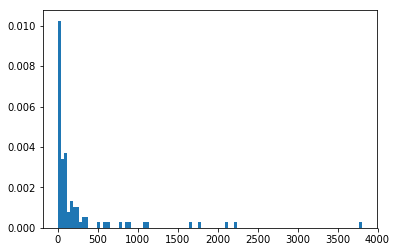

In [206]:
import scipy.stats as ss
# import numpy as np
# import matplotlib.pyplot as plt
# alpha, loc, beta=5, 100, 22
# data=ss.gamma.rvs(alpha,loc=loc,scale=beta,size=5000)
myHist = plt.hist(data_frechet, 100, normed=True)
# rv = ss.gamma(alpha,loc,beta)
# x = np.linspace(0,400) 
# h = plt.plot(x, ss.invweibull.pdf(x), lw=2)
plt.show()
# we wanted to plot the pdf function of the used density on the histogram below

C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


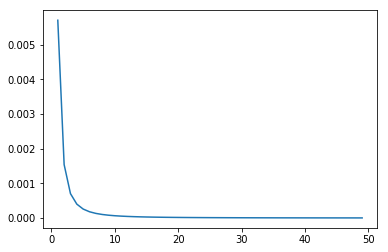

In [204]:
# hist = np.histogram(data_frechet)
# plt.hist(data_frechet,bins = 100)
import scipy.special as ss
# here we want to get a pdf to plot it on histogram
def fisher_den(x,alpha1,alpha2,beta1):
    return(1/ss.beta(alpha1,alpha2)*np.exp(-np.log(beta1)+(alpha1-1)*np.log(x/beta1)-(alpha1+alpha2)*np.log(1+x/beta1))) 
x = np.linspace(0,600) 
   
plt.plot(fisher_den(x,1,1,1))

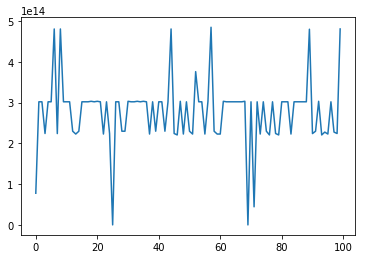

In [173]:
plt.plot(alpha1[0:100]) # we check whether we have convergence

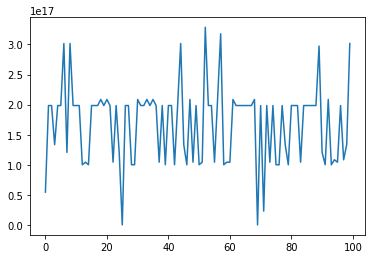

In [174]:
plt.plot(alpha2[0:100]) # we check convergence for the second parameter in the same way as before

In [ ]:
# fisher
from scipy.stats import f
df1, df2, N = 2, 1, 1000
r = f.rvs(df1, df2, size=N)
# r.tolist()

we get the \hat{beta}, \hat{gamma} values from fitted Fisher distribution to estiamte quantile values 
\hat{q}_{GPD} = u + ...

In [150]:
N = 5000
k = 100
data = dict(N = k,  y2 = data_frechet) 
# sm = StanModel(model_code=GPD) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4995339e5aaf6e92c78e547754614ea3 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [148]:
alpha = np.mean(list(fit.extract().values())[0].tolist())
beta = np.mean(list(fit.extract().values())[1].tolist())
# print(alpha, beta)

1.1653252952351447 1.5725595684023386


In [100]:
def quantile_GPD(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05

In [103]:
quant_gpd = quantile_GPD(N, k, 0.05, beta, 1/alpha, u)

In [102]:
def quantile_Fisher(N, F_y):
    return(u + F_y) # F_y is inversed survival function available for programmed .f distribution in python

44.77078340034417

In [106]:
df1 = np.mean(list(fit.extract().values())[0].tolist())
df2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1, alpha2, beta_f = df1 / 2, df2 / 2, df2 / df1
print(alpha1, alpha2, beta_f)

34013148.30470357 0.22691540796553988 6.671402656782597e-09


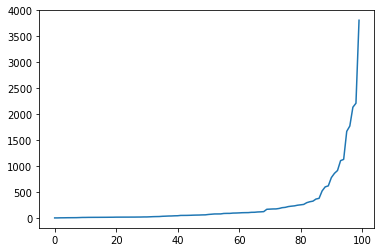

In [115]:
import matplotlib.pyplot as plt
plt.plot(data_frechet)
plt.show()

In [116]:
# alpha
# from scipy.stats import rv_continuous
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

In [124]:
ecdf = ECDF(data_frechet)


In [125]:
ecdf

In [152]:
np.median(data_frechet)

62.941114705451874